# Predicting the performance of social economically disadvantaged students and assess if they can be resilient students in the future

In this project, I will predict the math, science, read scores of social economically disadvantaged students. And predict if they can be resilient students. 
The data is from PISA data of 2018. I only used the OECD countries and several key variables. 
I will use clustering, regression, classfication to get the results. 

Zihua Lai

In [1]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# read the file of student 2018
student_2018 = pd.read_csv('student_2018.csv',encoding='latin1')
student_2018.head()

,year,country,school_id,student_id,mother_educ,father_educ,gender,computer,internet,math,...,stu_wgt,desk,room,dishwasher,television,computer_n,car,book,wealth,escs
0,2018,ALB,800002,800251,ISCED 3A,ISCED 3A,male,yes,yes,490.187,...,13.51452,yes,yes,NaN,3+,1,2,0-10,-0.0996,0.6747
1,2018,ALB,800002,800402,ISCED 2,ISCED 2,male,yes,yes,462.464,...,13.51452,yes,yes,NaN,1,1,2,11-25,-0.7221,-0.7566
2,2018,ALB,800002,801902,ISCED 2,ISCED 2,female,no,no,406.949,...,9.50669,yes,yes,NaN,1,0,0,0-10,-3.6051,-2.5112
3,2018,ALB,800002,803546,ISCED 2,ISCED 2,male,no,no,482.501,...,13.51452,yes,no,NaN,0,0,NaN,0-10,-7.0376,-3.1843
4,2018,ALB,800002,804776,ISCED 2,ISCED 3A,male,yes,yes,459.804,...,13.51452,yes,yes,NaN,2,1,0,11-25,-1.8375,-1.7557


Key Variable Explanation

1 There is no fixed "full score" for subjects like reading, mathematics, and science. These assessments are scaled, typically with the average score for OECD countries set around 500 and a standard deviation of about 100 points.

2 stu_wgt :it's not a score but a statistical weight assigned to each student's data to ensure the sample's representativeness of the population. It doesn't have a "full score" as it's used for data analysis, not to assess student performance. 

3 educ: (0) None, 
(1) <ISCED level 1> (primary education)
(2) <ISCED level 2> (lower secondary)
(3) <ISCED level 3B or 3C> (vocational/pre-vocational upper secondary)
(4) <ISCED level 3A> (general upper secondary) and/or <ISCED level 4> (non-tertiary post-secondary)
(5) <ISCED level 5B> (vocational tertiary) 
(6) <ISCED level 5A> and/or <ISCED level 6> (theoretically oriented tertiary and post-graduate)

4 ESCS: PISA index of economic, social and cultural status (ESCS)

In [3]:
# Remove columns of ID
data_2018 = student_2018.drop(columns=['year', 'country','school_id', 'student_id', 'computer_n'])

In [4]:
# change the variable of book to a numeric variable
# deal with books
print(data_2018['book'].unique())

# Define the mapping for the 'book' variable
book_mapping = {
    '0-10': 1,
    '11-25': 2,
    '26-100': 3,
    '101-200': 4,
    '201-500': 5,
    'more than 500': 6
}

# Apply the mapping to the 'book' column
data_2018['book'] = data_2018['book'].map(book_mapping)

# deal with television 
print(data_2018['television'].unique())
television_mapping = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3+': 3
}

# Apply the mapping to the 'television' column
data_2018['television'] = data_2018['television'].map(television_mapping)
data_2018['television'] = pd.to_numeric(data_2018['television'])

# Display the first few rows of the dataset
print(data_2018.head())

['0-10' '11-25' nan '26-100' '101-200' 'more than 500' '201-500']
['3+' '1' '0' '2' nan]
  mother_educ father_educ  gender computer internet     math     read  \
0    ISCED 3A    ISCED 3A    male      yes      yes  490.187  375.984   
1     ISCED 2     ISCED 2    male      yes      yes  462.464  434.352   
2     ISCED 2     ISCED 2  female       no       no  406.949  359.191   
3     ISCED 2     ISCED 2    male       no       no  482.501  425.131   
4     ISCED 2    ISCED 3A    male      yes      yes  459.804  306.028   

   science   stu_wgt desk room  dishwasher  television  car  book  wealth  \
0  445.039  13.51452  yes  yes         NaN         3.0    2   1.0 -0.0996   
1  421.731  13.51452  yes  yes         NaN         1.0    2   2.0 -0.7221   
2  392.223   9.50669  yes  yes         NaN         1.0    0   1.0 -3.6051   
3  515.942  13.51452  yes   no         NaN         0.0  NaN   1.0 -7.0376   
4  328.261  13.51452  yes  yes         NaN         2.0    0   2.0 -1.8375   

     escs

In [5]:
## Columns for imputation and removal
categorical_columns_to_impute = ['gender', 'computer', 'internet', 'desk', 'room', 'television', 'book']
numerical_columns_to_impute = ['math', 'read', 'science', 'wealth', 'escs']
columns_to_remove = ['dishwasher','car']

## Impute missing values for categorical columns with the mode
for column in categorical_columns_to_impute:
    mode_value = data_2018[column].mode()[0]
    data_2018[column].fillna(mode_value, inplace=True)
    

## Impute missing values for numerical columns with the median
for column in numerical_columns_to_impute:
    median_value = data_2018[column].median()
    data_2018[column].fillna(median_value, inplace=True)

## Remove columns with a high percentage of missing values or not crucial for analysis
data_2018.drop(columns=columns_to_remove, inplace=True)


In [6]:
unique_mother_educ = data_2018['mother_educ'].unique()
unique_father_educ = data_2018['father_educ'].unique()
# Print the unique values
print("Unique values in education level:", unique_mother_educ)
print("Unique values in education level:", unique_father_educ)

Unique values in education level: ['ISCED 3A' 'ISCED 2' nan 'ISCED 1' 'less than ISCED1' 'ISCED 3B, C']
Unique values in education level: ['ISCED 3A' 'ISCED 2' nan 'ISCED 1' 'ISCED 3B, C' 'less than ISCED1']


In [7]:
# encode the education levels to numeric values
education_mapping = {
    "ISCED 1": 1,  # primary education
    'ISCED 2': 2,  # lower secondary
    "ISCED 3B, C": 3,  # vocational/pre-vocational upper secondary
    'ISCED 3A': 4,  # general upper secondary
    'less than ISCED1':0 # almost didn't attend school
}

# Apply the mapping to the education columns
data_2018['mother_educ'] = data_2018['mother_educ'].map(education_mapping)
data_2018['father_educ'] = data_2018['father_educ'].map(education_mapping)

# Display the first few rows of the dataset
print(data_2018.head())

   mother_educ  father_educ  gender computer internet     math     read  \
0          4.0          4.0    male      yes      yes  490.187  375.984   
1          2.0          2.0    male      yes      yes  462.464  434.352   
2          2.0          2.0  female       no       no  406.949  359.191   
3          2.0          2.0    male       no       no  482.501  425.131   
4          2.0          4.0    male      yes      yes  459.804  306.028   

   science   stu_wgt desk room  television  book  wealth    escs  
0  445.039  13.51452  yes  yes         3.0   1.0 -0.0996  0.6747  
1  421.731  13.51452  yes  yes         1.0   2.0 -0.7221 -0.7566  
2  392.223   9.50669  yes  yes         1.0   1.0 -3.6051 -2.5112  
3  515.942  13.51452  yes   no         0.0   1.0 -7.0376 -3.1843  
4  328.261  13.51452  yes  yes         2.0   2.0 -1.8375 -1.7557  


In [8]:
# deal with the NA values of mother and father education level. 
## If only one person information is missing, then fill in the same level with spouse. 
## If both of parent don't have education information, then remove this record

## define a function to deal with the missing value
def handle_parents_education(row):
    if pd.isna(row['mother_educ']) and not pd.isna(row['father_educ']):
        return row['father_educ']
    elif not pd.isna(row['mother_educ']) and pd.isna(row['father_educ']):
        return row['mother_educ']
    return row['mother_educ']

## apply this function
data_2018['mother_educ'] = data_2018.apply(lambda row: handle_parents_education(row), axis=1)
data_2018['father_educ'] = data_2018.apply(lambda row: handle_parents_education(row), axis=1)

## delete the records with missing values of both parent
data_2018.dropna(subset=['mother_educ', 'father_educ'], inplace=True)

# display the final result
print(data_2018.head())


   mother_educ  father_educ  gender computer internet     math     read  \
0          4.0          4.0    male      yes      yes  490.187  375.984   
1          2.0          2.0    male      yes      yes  462.464  434.352   
2          2.0          2.0  female       no       no  406.949  359.191   
3          2.0          2.0    male       no       no  482.501  425.131   
4          2.0          2.0    male      yes      yes  459.804  306.028   

   science   stu_wgt desk room  television  book  wealth    escs  
0  445.039  13.51452  yes  yes         3.0   1.0 -0.0996  0.6747  
1  421.731  13.51452  yes  yes         1.0   2.0 -0.7221 -0.7566  
2  392.223   9.50669  yes  yes         1.0   1.0 -3.6051 -2.5112  
3  515.942  13.51452  yes   no         0.0   1.0 -7.0376 -3.1843  
4  328.261  13.51452  yes  yes         2.0   2.0 -1.8375 -1.7557  


In [9]:
# encode to binary values
# Encoding the 'gender' column: female = 0, male = 1
data_2018['gender'] = data_2018['gender'].map({'female': 0, 'male': 1})

# Encoding other binary columns: yes = 1, no = 0
binary_columns = ['computer', 'internet', 'desk', 'room']
for column in binary_columns:
    data_2018[column] = data_2018[column].map({'yes': 1, 'no': 0})

# Display the first few rows of the dataset after encoding
print(data_2018.head())

   mother_educ  father_educ  gender  computer  internet     math     read  \
0          4.0          4.0       1         1         1  490.187  375.984   
1          2.0          2.0       1         1         1  462.464  434.352   
2          2.0          2.0       0         0         0  406.949  359.191   
3          2.0          2.0       1         0         0  482.501  425.131   
4          2.0          2.0       1         1         1  459.804  306.028   

   science   stu_wgt  desk  room  television  book  wealth    escs  
0  445.039  13.51452     1     1         3.0   1.0 -0.0996  0.6747  
1  421.731  13.51452     1     1         1.0   2.0 -0.7221 -0.7566  
2  392.223   9.50669     1     1         1.0   1.0 -3.6051 -2.5112  
3  515.942  13.51452     1     0         0.0   1.0 -7.0376 -3.1843  
4  328.261  13.51452     1     1         2.0   2.0 -1.8375 -1.7557  


In [10]:
# how many missing values each variables have
missing_values = data_2018.isnull().sum()
# Display the number of missing values for each column
print(missing_values)

mother_educ    0
father_educ    0
gender         0
computer       0
internet       0
math           0
read           0
science        0
stu_wgt        0
desk           0
room           0
television     0
book           0
wealth         0
escs           0
dtype: int64


In [11]:
#checking for missing values again
missing_values_after_adjustments = data_2018.isnull().sum()

# Display if there are any remaining missing values
print(missing_values_after_adjustments[missing_values_after_adjustments > 0])

Series([], dtype: int64)


In [12]:
print(data_2018.head())

   mother_educ  father_educ  gender  computer  internet     math     read  \
0          4.0          4.0       1         1         1  490.187  375.984   
1          2.0          2.0       1         1         1  462.464  434.352   
2          2.0          2.0       0         0         0  406.949  359.191   
3          2.0          2.0       1         0         0  482.501  425.131   
4          2.0          2.0       1         1         1  459.804  306.028   

   science   stu_wgt  desk  room  television  book  wealth    escs  
0  445.039  13.51452     1     1         3.0   1.0 -0.0996  0.6747  
1  421.731  13.51452     1     1         1.0   2.0 -0.7221 -0.7566  
2  392.223   9.50669     1     1         1.0   1.0 -3.6051 -2.5112  
3  515.942  13.51452     1     0         0.0   1.0 -7.0376 -3.1843  
4  328.261  13.51452     1     1         2.0   2.0 -1.8375 -1.7557  


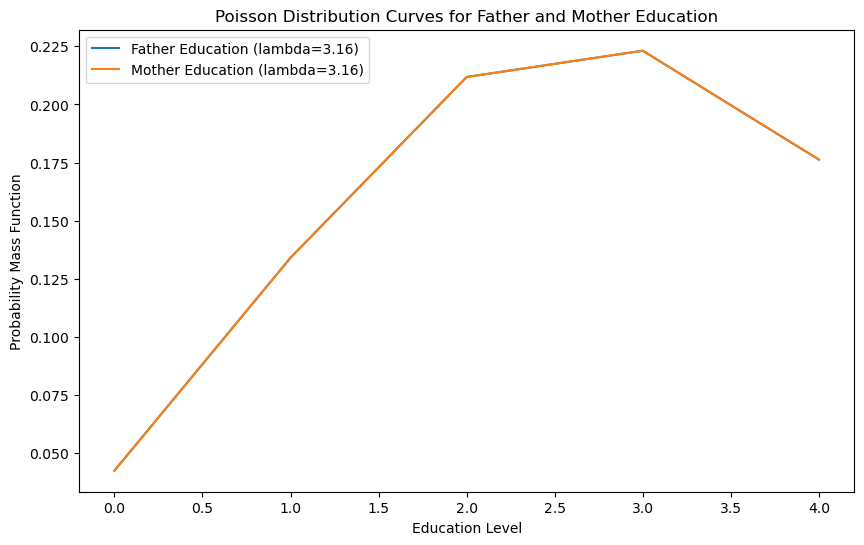

In [13]:
# display the probability distribution curve of all of the variables now
# For continous vairables, I use normal distribution.
# For discrete variables, I use possion distribution
import seaborn as sb
from scipy.stats import norm, poisson

# Calculate the mean and standard deviation for the father's education
father_mean = data_2018['father_educ'].mean()
father_std = data_2018['father_educ'].std()

# Calculate the mean and standard deviation for the mother's education
mother_mean = data_2018['mother_educ'].mean()
mother_std = data_2018['mother_educ'].std()

# Define the range of x values to cover both father's and mother's education ranges
x_min = min(data_2018['father_educ'].min(), data_2018['mother_educ'].min())
x_max = max(data_2018['father_educ'].max(), data_2018['mother_educ'].max())
x_values = np.linspace(x_min, x_max, 1000)

# Create the possion distribution curves
# Calculate the lambda (mean) for the Poisson distribution
father_lambda = data_2018['father_educ'].mean()
mother_lambda = data_2018['mother_educ'].mean()

# Define the range of x values to cover the range of 'father_educ' and 'mother_educ'
xmin = min(0, data_2018['father_educ'].min(), data_2018['mother_educ'].min())
xmax = max(data_2018['father_educ'].max(), data_2018['mother_educ'].max())
x_values = np.arange(xmin, xmax + 1)  # Poisson is defined for discrete values

# Create the Poisson distribution curves
father_pdf = poisson.pmf(x_values, father_lambda)
mother_pdf = poisson.pmf(x_values, mother_lambda)

# Plot the distribution curves
plt.figure(figsize=(10, 6))
plt.plot(x_values, father_pdf, label=f'Father Education (lambda={father_lambda:.2f})')
plt.plot(x_values, mother_pdf, label=f'Mother Education (lambda={mother_lambda:.2f})')

# Add titles and labels
plt.title('Poisson Distribution Curves for Father and Mother Education')
plt.xlabel('Education Level')
plt.ylabel('Probability Mass Function')
plt.legend()

# Display the plot
plt.show()

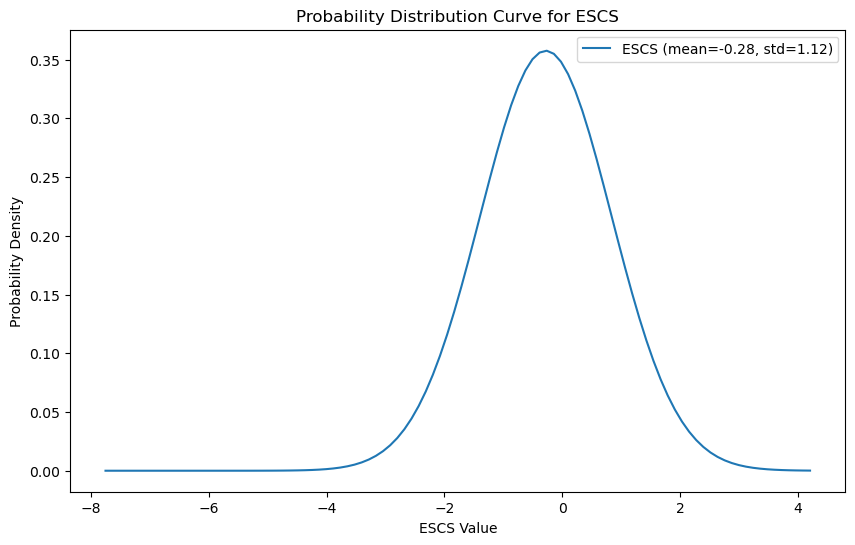

In [14]:
# distribution of ESCS index
# Calculate the distribution parameters for ESCS
escs_mean = data_2018['escs'].mean()
escs_std = data_2018['escs'].std()

# Set the range of x values for ESCS
xmin, xmax = data_2018['escs'].min(), data_2018['escs'].max()
x_values = np.linspace(xmin, xmax, 100)

# Generate the normal distribution curve for ESCS
escs_pdf = norm.pdf(x_values, escs_mean, escs_std)

# Plot the distribution curve for ESCS
plt.figure(figsize=(10, 6))
sb.lineplot(x = x_values, y =escs_pdf, label=f'ESCS (mean={escs_mean:.2f}, std={escs_std:.2f})')

# Add titles and labels
plt.title('Probability Distribution Curve for ESCS')
plt.xlabel('ESCS Value')
plt.ylabel('Probability Density')

# Show legend
plt.legend()

# Display the plot
plt.show()


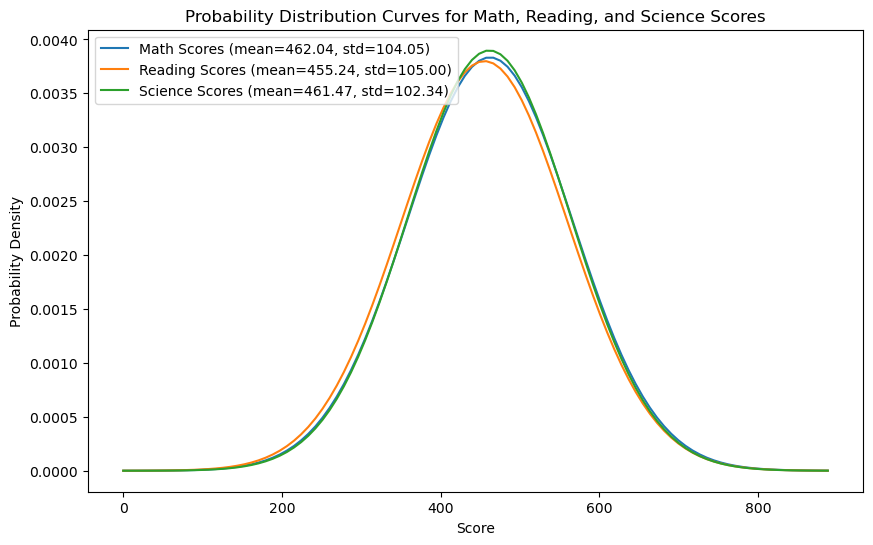

In [14]:
# The distribution of math, reading and science scores
# Calculate the distribution parameters
math_mean, math_std = norm.fit(data_2018['math'])
read_mean, read_std = norm.fit(data_2018['read'])
science_mean, science_std = norm.fit(data_2018['science'])

# Set the range of x values to cover the scores range
xmin = min(data_2018['math'].min(), data_2018['read'].min(), data_2018['science'].min())
xmax = max(data_2018['math'].max(), data_2018['read'].max(), data_2018['science'].max())
x_values = np.linspace(xmin, xmax, 100)

# Generate the normal distribution curves
math_pdf = norm.pdf(x_values, math_mean, math_std)
read_pdf = norm.pdf(x_values, read_mean, read_std)
science_pdf = norm.pdf(x_values, science_mean, science_std)

# Plot the distribution curves
plt.figure(figsize=(10, 6))

sb.lineplot(x = x_values, y = math_pdf, label=f'Math Scores (mean={math_mean:.2f}, std={math_std:.2f})')
sb.lineplot(x =x_values, y = read_pdf, label=f'Reading Scores (mean={read_mean:.2f}, std={read_std:.2f})')
sb.lineplot(x = x_values, y = science_pdf, label=f'Science Scores (mean={science_mean:.2f}, std={science_std:.2f})')

# Add titles and labels
plt.title('Probability Distribution Curves for Math, Reading, and Science Scores')
plt.xlabel('Score')
plt.ylabel('Probability Density')
plt.legend()

# Display the plot
plt.show()

According to the results of plots, we can know that parents education levels are mainly in 2.0 to 3.0
The scores for 3 subjects are almost same. 
And the ESCS index has the mean almost equal to 0, but standard deviation equals to 1. And it is a left skewed distribution. It means small part of family, has more money and good sate than the money of large part of people

Now I want to predict the socres of social economically disadvantaged students and assess if they are resilient.
(Note: Resilient means the students have difficulty from their family or health but can still acheive great results).

1 How do I define the students as social economically disadvantaged ? Here I use the bottom 20% of escs index to measure. (escs is a index that used to measure the social economical state, including wealth and social position).

2 How do I define the students have good performance ? Here I need an absolute value as threshold. Because no matter if they are difficult from their families, they need to be as good as other excellent students. Only in this way, they will have chance to acheive more. 
Here, I need to think about following problems. 
1 ) If I use the top 20% of 3 subjects independently, then it will be unfair to some students who are especially good at one subject and dislike another one. 
2 ) If I use the top 20% of total scores for 3 subjects. Then it will be bad when there are extreme cases. For example, the student has mathmatics of 0, and others get very high. 
So, I used clustering first to put similar students into corresponed clusters. Then I predict the mean scores of each subjects for each clusters. At last, I will pick the highest mean score in one cluster as the threshold.  


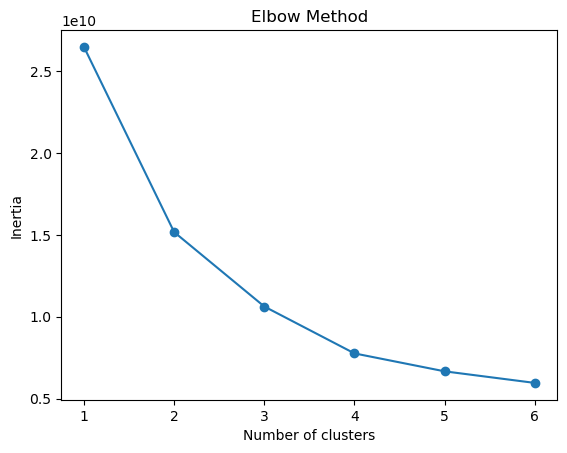

In [15]:
# Use K-Means for clustering
## here I use elbow method to decide the number of K . I cannot use silhoutte because there are 500,000 data entries

inertia = []  # Sum of squared distances of samples to their closest cluster center
for k in range(1, 7):  # Testing 1 to 6 clusters
    kmeans = KMeans(n_clusters=k, n_init=2, random_state=42)
    kmeans.fit(data_2018)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method results
plt.plot(range(1, 7), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [16]:
# according to the plot of elbow method, I should choose the elbow point of 4. 
# Now I set K = 4 , and use K- means algo
# Perform K-Means clustering
kmeans = KMeans(n_clusters=4, n_init=2, random_state=42)
kmeans.fit(data_2018)

# Getting the cluster labels
cluster_labels = kmeans.labels_

# Adding cluster labels to your original DataFrame
data_2018['Cluster'] = cluster_labels

# Display the first few rows with cluster labels
print(data_2018.head())

   mother_educ  father_educ  gender  computer  internet     math     read  \
0          4.0          4.0       1         1         1  490.187  375.984   
1          2.0          2.0       1         1         1  462.464  434.352   
2          2.0          2.0       0         0         0  406.949  359.191   
3          2.0          2.0       1         0         0  482.501  425.131   
4          2.0          2.0       1         1         1  459.804  306.028   

   science   stu_wgt  desk  room  television  book  wealth    escs  Cluster  
0  445.039  13.51452     1     1         3.0   1.0 -0.0996  0.6747        0  
1  421.731  13.51452     1     1         1.0   2.0 -0.7221 -0.7566        0  
2  392.223   9.50669     1     1         1.0   1.0 -3.6051 -2.5112        2  
3  515.942  13.51452     1     0         0.0   1.0 -7.0376 -3.1843        0  
4  328.261  13.51452     1     1         2.0   2.0 -1.8375 -1.7557        2  


/Users/zihualai/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


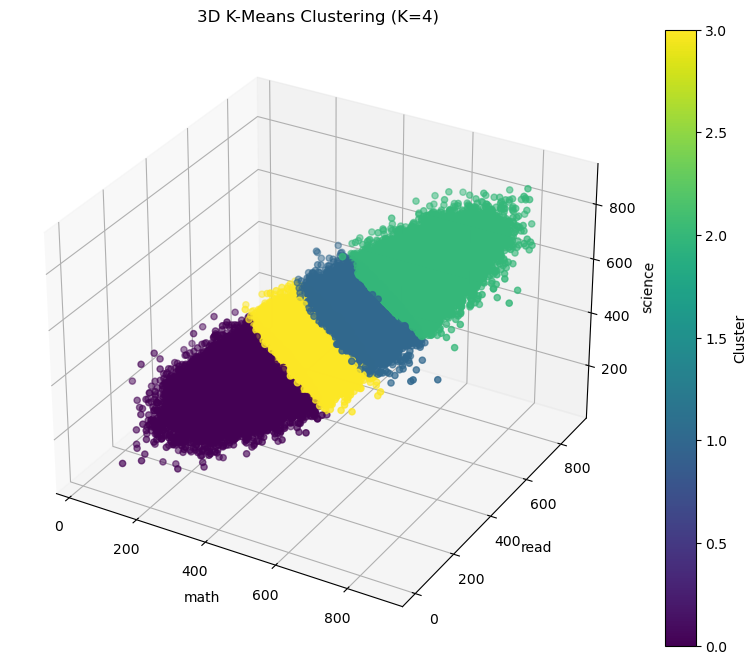

In [17]:
# Now I visualize my clustering results in 3D
from mpl_toolkits.mplot3d import Axes3D

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_2018[['math', 'read', 'science']])
data_2018['Cluster'] = kmeans.labels_

# Define the features for the axes
x_axis = 'math'
y_axis = 'read'
z_axis = 'science'

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using cluster labels to color the points
scatter = ax.scatter(data_2018[x_axis], data_2018[y_axis], data_2018[z_axis], 
                     c=data_2018['Cluster'], cmap='viridis', marker='o')

# Labels and title
ax.set_xlabel(x_axis)
ax.set_ylabel(y_axis)
ax.set_zlabel(z_axis)
plt.title('3D K-Means Clustering (K=4)')

# Color bar
plt.colorbar(scatter, ax=ax, label='Cluster')

# Show the plot
plt.show()

In [18]:
# Now explore the features of the clusters
centroids = kmeans.cluster_centers_

for i, centroid in enumerate(centroids):
    print(f"Cluster {i} centroid features:")
    print(centroid)
    print()

Cluster 0 centroid features:
[328.25530911 317.43524733 330.14707676]

Cluster 1 centroid features:
[516.57404397 505.08068916 515.14689086]

Cluster 2 centroid features:
[609.88161205 609.8910702  613.02653755]

Cluster 3 centroid features:
[426.91016643 423.64268453 423.82085738]



In [19]:
# Now i will explore the features of these 4 clusters
centroids = kmeans.cluster_centers_

for i, centroid in enumerate(centroids):
    print(f"Cluster {i} centroid features:")
    print(centroid)


Cluster 0 centroid features:
[328.25530911 317.43524733 330.14707676]
Cluster 1 centroid features:
[516.57404397 505.08068916 515.14689086]
Cluster 2 centroid features:
[609.88161205 609.8910702  613.02653755]
Cluster 3 centroid features:
[426.91016643 423.64268453 423.82085738]


In [21]:
# I want to know the value of other variables for these centroids
features = data_2018.drop('Cluster', axis=1)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(features)

centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=features.columns)
print(centroids_df)


/Users/zihualai/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


   mother_educ  father_educ    gender  computer  internet        math  \
0     3.197422     3.197422  0.475927  0.852758  0.940546  465.869543   
1     2.781927     2.781927  0.542850  0.690318  0.830507  347.453969   
2     3.526119     3.526119  0.489480  0.938596  0.986327  583.678390   
3     2.975494     2.975494  0.499949  0.610228  0.734076  427.115237   

         read     science     stu_wgt      desk      room  television  \
0  459.327449  462.949003   34.336147  0.908431  0.821142    2.153659   
1  338.809976  347.472398   38.812785  0.799012  0.771129    1.970546   
2  577.412660  584.925828   32.617748  0.954881  0.866290    2.089189   
3  437.371720  447.491034  734.681224  0.773165  0.844658    2.020861   

       book    wealth      escs  
0  2.849060 -0.361609 -0.252836  
1  2.229630 -0.905629 -0.835175  
2  3.674239  0.003365  0.319217  
3  2.547139 -0.961123 -0.776849  


read, internet, and science has same trend and almost overlapped. 
Probably, in 2018, internet has become the main channel for reading and science. So,internet, computer ,will be very important for a family

In [23]:
# Calculate the mean for each cluster for the 'math', 'read', and 'science' columns
cluster_average_scores = data_2018.groupby('Cluster')[['math', 'read', 'science']].mean()

# Display the average scores for each cluster
print(cluster_average_scores)

               math        read     science
Cluster                                    
0        328.079363  317.244252  330.005751
1        516.292013  504.818457  514.867741
2        609.707700  609.660460  612.822545
3        426.654276  423.394971  423.550882


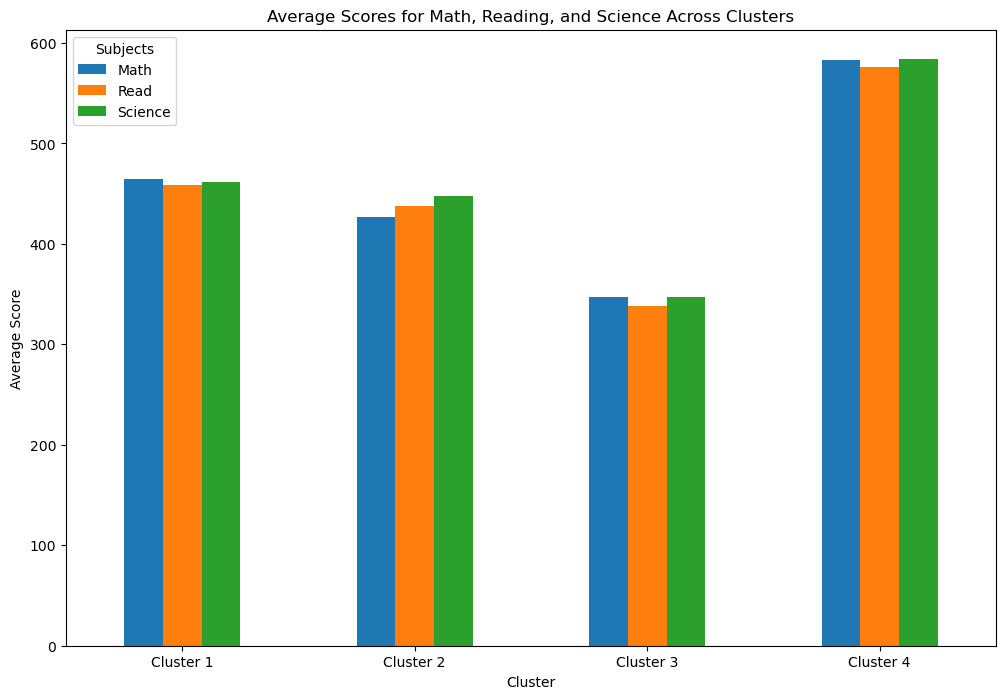

In [20]:
# create a bar plot to show the average scores of 4 clusters
# Given data
data = {
    'Cluster': ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'],
    'Math': [464.702670, 427.146641, 346.650692, 582.813276],
    'Read': [458.272605, 437.403306, 337.932894, 576.413977],
    'Science': [461.768976, 447.531137, 346.709280, 584.017946]
}

# Create DataFrame
cluster_averages = pd.DataFrame(data).set_index('Cluster')

# Plotting
cluster_averages.plot(kind='bar', figsize=(12, 8))
plt.title('Average Scores for Math, Reading, and Science Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Average Score')
plt.xticks(rotation=0)  # Ensure the cluster labels are horizontal for readability
plt.legend(title='Subjects')
plt.show()


So, here I found that the highest scores are in the 4th cluster. Which the average scores of math, read, science are over 600. I will set these 3 numbers as the threshold of resilient. The social economically disadvantaged students must have scores over these 3 numbers , can be defined as resilient students

In [21]:
# define the bottom 25% ESCS index students as social economically disadvantaged students
# Determine the 25th percentile of the ESCS index
escs_25th_percentile = data_2018['escs'].quantile(0.25)

# Define a new column 'socio_economic_status' where 1 indicates bottom 25% ESCS index (socially economically disadvantaged)
data_2018['socio_economic_status'] = np.where(data_2018['escs'] <= escs_25th_percentile, 'disadvantaged', 'not disadvantaged')

# Display the first few rows of the DataFrame to verify
print(data_2018[['escs', 'socio_economic_status']].head())

     escs socio_economic_status
0  0.6747     not disadvantaged
1 -0.7566     not disadvantaged
2 -2.5112         disadvantaged
3 -3.1843         disadvantaged
4 -1.7557         disadvantaged


Part I : predict the scores of 3 subjects for the social economically disadvantaged students with different regression methods and compare them.

Here I used Linear Regression and Decision Tree Regression and cross validation to comparet the performance with negative MSE value. 
Why I choose regression tree ? 
Because regression tree can deal with all of the types of data and will have a good prediction result if each leaf corresponds to a different cluster of points in the graph 

Why I use linear regeression ?
Because there is a main independent variable called escs, it is a continous variable and it has the linear relationship with scores. It is the easiest model but can explain a lot of things. 

In [22]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Convert 'socio_economic_status' to numeric values
data_2018['socio_economic_status'] = data_2018['socio_economic_status'].map({'disadvantaged': 1, 'not disadvantaged': 0})


# Define predictors and targets
X = data_2018.drop(['math', 'read', 'science'], axis=1)
y_math = data_2018['math']
y_read = data_2018['read']
y_science = data_2018['science']

# Add a constant for statsmodels
X_const = sm.add_constant(X)

# Split data into train and test sets for each target
X_train, X_test, y_train_math, y_test_math = train_test_split(X_const, y_math, test_size=0.2, random_state=42)
X_train, X_test, y_train_read, y_test_read = train_test_split(X_const, y_read, test_size=0.2, random_state=42)
X_train, X_test, y_train_science, y_test_science = train_test_split(X_const, y_science, test_size=0.2, random_state=42)

# Define models
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42)
}

# Perform 5-fold cross-validation and calculate MSE
# cross_val_score returns negative MSE scores because by convention higher numbers are better (which is not the case with MSE)

for model_name, model in models.items():
    for target_name, y_train in [('Math', y_train_math), ('Read', y_train_read), ('Science', y_train_science)]:
        mse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        average_mse = -mse_scores.mean()  # Negate the values to get positive MSE scores
        print(f'Average MSE for {model_name} on {target_name}: {average_mse}')

print(f'Average MSE from 5-fold cross-validation: {average_mse}')


Average MSE for LinearRegression on Math: 7942.786532503133
Average MSE for LinearRegression on Read: 8079.470218716965
Average MSE for LinearRegression on Science: 7878.189886395516
Average MSE for DecisionTreeRegressor on Math: 4529.312356606754
Average MSE for DecisionTreeRegressor on Read: 4179.937865359783
Average MSE for DecisionTreeRegressor on Science: 3823.8305366579807
Average MSE from 5-fold cross-validation: 3823.8305366579807


In [23]:
# Select features excluding 'socio_economic_status' and targets for the whole dataset
X_full = data_2018.drop(['math', 'read', 'science', 'socio_economic_status'], axis=1)
y_math_full = data_2018['math']
y_read_full = data_2018['read']
y_science_full = data_2018['science']

# Train Decision Tree Regressors for each subject
dt_regressor_math = DecisionTreeRegressor(random_state=42).fit(X_full, y_math_full)
dt_regressor_read = DecisionTreeRegressor(random_state=42).fit(X_full, y_read_full)
dt_regressor_science = DecisionTreeRegressor(random_state=42).fit(X_full, y_science_full)

disadvantaged_students = data_2018[data_2018['socio_economic_status'] == 1]

# Prepare the feature matrix for prediction
X_disadvantaged = disadvantaged_students.drop(['math', 'read', 'science', 'socio_economic_status'], axis=1)

# Predict the scores for disadvantaged students using the trained models
disadvantaged_students['predicted_math_score'] = dt_regressor_math.predict(X_disadvantaged)
disadvantaged_students['predicted_read_score'] = dt_regressor_read.predict(X_disadvantaged)
disadvantaged_students['predicted_science_score'] = dt_regressor_science.predict(X_disadvantaged)

# Show the predicted scores for disadvantaged students
predicted_scores = disadvantaged_students[['predicted_math_score', 'predicted_read_score', 'predicted_science_score']]
print(predicted_scores.head())

   predicted_math_score  predicted_read_score  predicted_science_score
2               406.949               359.191                  392.223
3               482.501               425.131                  515.942
4               459.804               306.028                  328.261
5               367.165               352.271                  284.263
7               441.037               271.213                  391.562


/var/folders/z9/q9krs1y56_nfwpr9jpnkv_gh0000gn/T/ipykernel_47992/925809635.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disadvantaged_students['predicted_math_score'] = dt_regressor_math.predict(X_disadvantaged)
/var/folders/z9/q9krs1y56_nfwpr9jpnkv_gh0000gn/T/ipykernel_47992/925809635.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disadvantaged_students['predicted_read_score'] = dt_regressor_read.predict(X_disadvantaged)
/var/folders/z9/q9krs1y56_nfwpr9jpnkv_gh0000gn/T/ipykernel_47992/9258096

In [24]:
# Now I want to get the average scores of prediction for social economically disadvantaged students
# Calculate the average predicted scores for each subject
average_predicted_math_score = disadvantaged_students['predicted_math_score'].mean()
average_predicted_read_score = disadvantaged_students['predicted_read_score'].mean()
average_predicted_science_score = disadvantaged_students['predicted_science_score'].mean()

# Print the average predicted scores
print(f"Average predicted math score: {average_predicted_math_score}")
print(f"Average predicted read score: {average_predicted_read_score}")
print(f"Average predicted science score: {average_predicted_science_score}")


Average predicted math score: 405.5653175181248
Average predicted read score: 401.5891830055202
Average predicted science score: 409.010097620962


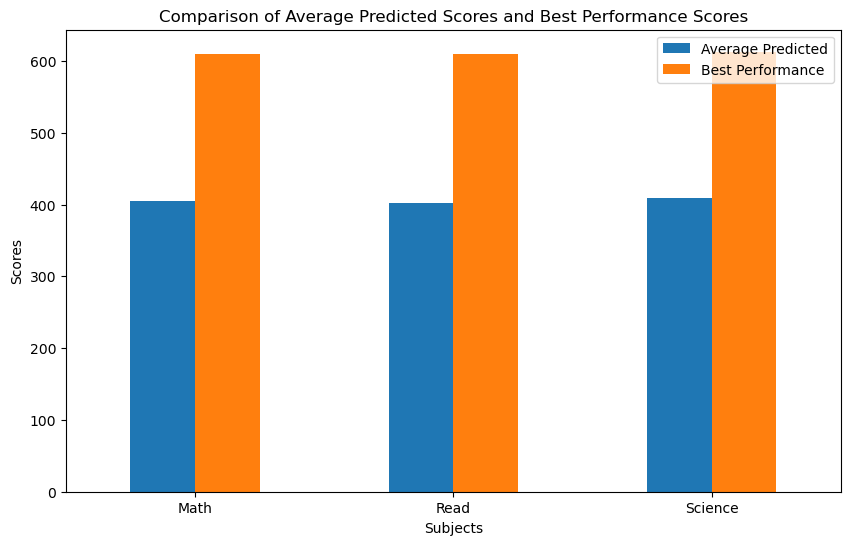

In [36]:
# Now let me use a barplot to compare the average scores of scocio economically disadvantaged students and students from best performance cluster
# Average predicted scores
predicted_scores = {
    'Math': 405.5653175181248,
    'Read': 401.5891830055202,
    'Science': 409.010097620962
}

# Best performance scores
best_performance_scores = {
    'Math': 609.707700,
    'Read': 609.660460,
    'Science': 612.822545
}

# Creating DataFrame for plotting
scores_df = pd.DataFrame([predicted_scores, best_performance_scores], 
                         index=['Average Predicted', 'Best Performance'])

# Transpose the DataFrame for plotting
scores_df = scores_df.T

# Creating the bar plot
scores_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Average Predicted Scores and Best Performance Scores')
plt.ylabel('Scores')
plt.xlabel('Subjects')
plt.xticks(rotation=0)
plt.show()

Then I will use classification to assess if the students can be resilient students. The students must past the threhold of 600 for 3 subjects can be counted as resilient

Here I will use classification tree firstly 
I need to consider dealing with imbalanced datasets, such as SMOTE (Synthetic Minority Over-sampling Technique), adjusting class weights, or collecting more balanced data.

Why I use classification tree ?
1 classification tree can deal with all of the data type, including continous variable. Because it can sort the continous variable first, then cut them into many blocks, then use the average of these blocks to be nodes. 
2 classification tree is easy to read
3 logistic regression, cannot deal with the continous variable
4 SVM is suitble for the situation with high feature dimensions because this algo can always make the dimension less. Also good for the situation without clear boundadries. It is very bad for big dataset. So in this dataset, I don't need it. 

What I will do in the process of classfication tree?
1 I will use gini impurity to decide the root and nodes
2 I will use cross validation to decide how many records should be in one leaf to make sure the accuracy. 
3 I will use confusion matrix , ROC, AUC, to check the performance

In [37]:
pip install --upgrade scikit-learn imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [25]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm

In [26]:
# Split the data into features and target variables for math, read, and science
X = data_2018.drop(['math', 'read', 'science'], axis=1)
y_math = data_2018['math']
y_read = data_2018['read']
y_science = data_2018['science']

# Add a constant term to the features for models 
X_with_const = sm.add_constant(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train_math, y_test_math = train_test_split(X_with_const, y_math, test_size=0.2, random_state=42)
X_train, X_test, y_train_read, y_test_read = train_test_split(X_with_const, y_read, test_size=0.2, random_state=42)
X_train, X_test, y_train_science, y_test_science = train_test_split(X_with_const, y_science, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree models
dt_model_math = DecisionTreeRegressor(random_state=42)
dt_model_math.fit(X_train, y_train_math)

dt_model_read = DecisionTreeRegressor(random_state=42)
dt_model_read.fit(X_train, y_train_read)

dt_model_science = DecisionTreeRegressor(random_state=42)
dt_model_science.fit(X_train, y_train_science)

# Use the models to make predictions on the same data structure used for training
data_2018['predicted_math_score'] = dt_model_math.predict(X_with_const)
data_2018['predicted_read_score'] = dt_model_read.predict(X_with_const)
data_2018['predicted_science_score'] = dt_model_science.predict(X_with_const)


In [27]:
# Apply SMOTE to generate synthetic samples for the minority class

smote = SMOTE(random_state=42)

# Thresholds
math_threshold = 600
read_threshold = 600
science_threshold = 600

# Define resilience: 1 if all scores meet the threshold, 0 otherwise
data_2018['resilient'] = ((data_2018['predicted_math_score'] >= math_threshold) &
                          (data_2018['predicted_read_score'] >= read_threshold) &
                          (data_2018['predicted_science_score'] >= science_threshold)).astype(int)

# Filter to socially economically disadvantaged students
disadvantaged_students = data_2018[data_2018['socio_economic_status'] == 1]

# Features and target
X_disadvantaged = disadvantaged_students.drop(['math', 'read', 'science', 'predicted_math_score', 
                                               'predicted_read_score', 'predicted_science_score', 
                                               'resilient', 'socio_economic_status'], axis=1)
y_resilient = disadvantaged_students['resilient']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_disadvantaged, y_resilient, test_size=0.2, random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


# Initialize the Decision Tree Classifier model
dt_classifier = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV to find the optimal number of samples per leaf
parameters = {'min_samples_leaf': range(1, 51)}
grid_search = GridSearchCV(dt_classifier, parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote)

# Get the best number of samples per leaf
best_min_samples = grid_search.best_params_['min_samples_leaf']
print(f"Best minimum samples per leaf: {best_min_samples}")

# Train the Decision Tree Classifier using the best parameter
dt_classifier = DecisionTreeClassifier(random_state=42, min_samples_leaf=best_min_samples)
dt_classifier.fit(X_train_smote, y_train_smote)

# Predict and evaluate the model
y_pred = dt_classifier.predict(X_test)
y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]


Best minimum samples per leaf: 1


Confusion Matrix:
[[29084   276]
 [  158    83]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     29360
           1       0.23      0.34      0.28       241

    accuracy                           0.99     29601
   macro avg       0.61      0.67      0.63     29601
weighted avg       0.99      0.99      0.99     29601

ROC AUC: 0.6674988976449172


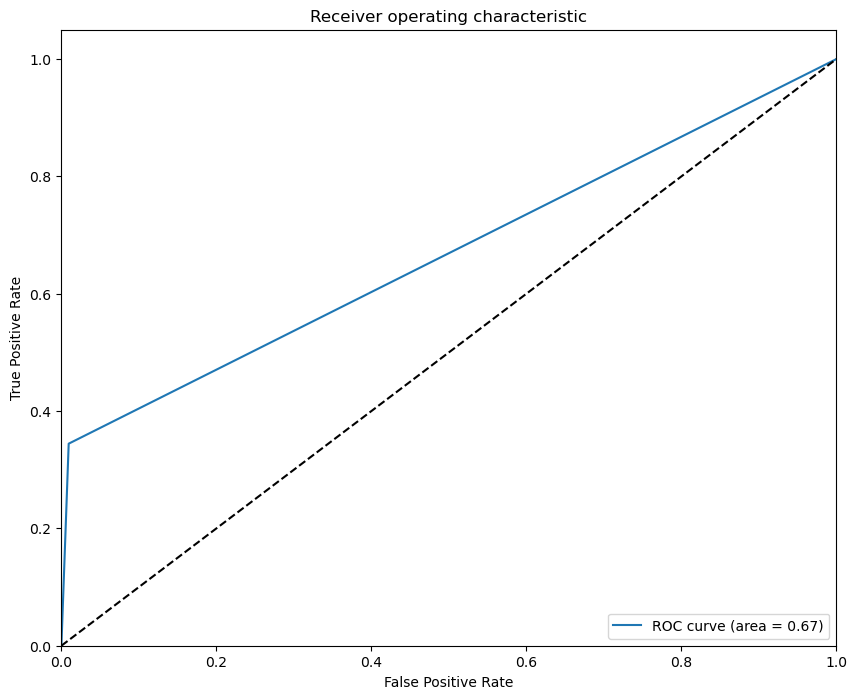

In [29]:
# evaluate the classification tree model
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
classif_report = classification_report(y_test, y_pred)

# Output the performance metrics
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classif_report}")
print(f"ROC AUC: {roc_auc}")

# Plot ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The best classification model here I guess it should be Xgboost model. 
it is suitble for big dataset, Suitble for dealing with imbalanced data, Will prevent the overfit situation very well
It is good at dealing with features which have changed to numbers.

Random Forest can also deal with imbalanced data in a good way. But it will be very huge and difficult for people to understand. It is also not good for dealing with the situation only has 2 classify results. 

In [31]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


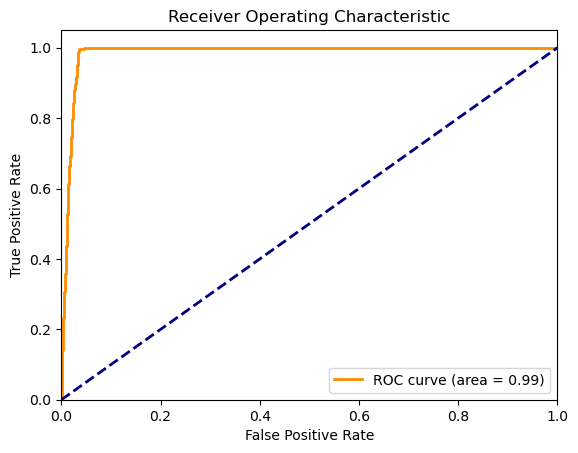

Confusion Matrix:
[[28943   417]
 [   93   148]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29360
           1       0.26      0.61      0.37       241

    accuracy                           0.98     29601
   macro avg       0.63      0.80      0.68     29601
weighted avg       0.99      0.98      0.99     29601



In [32]:
# Now I use XGboost method
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train_smote, y_train_smote)

# Predict probabilities and make predictions on the test set
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


The ROC curve is very close to the top left corner, indicating a high true positive rate (TPR) and a low false positive rate (FPR).
The AUC is 0.99 out of 1, which is an excellent score. This means the model is doing an outstanding job in distinguishing between the resilient and non-resilient students.

The model is excellent at identifying non-resilient students but struggles with identifying resilient students.
But probably the threshold need to be adjusted in the future. Because now the imbalance is heavy

In [49]:
# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit the classifier to the resampled training data
xgb_classifier.fit(X_train_smote, y_train_smote)

# Make predictions with the XGBoost model
X_disadvantaged['predicted_resilience_probability_xgb'] = xgb_classifier.predict_proba(X_disadvantaged)[:, 1]

# Calculate the mean predicted resilience probability
mean_predicted_resilience_probability_xgb = X_disadvantaged['predicted_resilience_probability_xgb'].mean()
print(f"Mean Predicted Resilience Probability (XGBoost): {mean_predicted_resilience_probability_xgb}")

Mean Predicted Resilience Probability (XGBoost): 0.018291477113962173


according to the result, there is only 1.8% chance that a social economically disadvantaged student to get the excellent scores same as the best performance group
